# Анализ рекламных объявлений


## Описание данных:


| Поле                         | Описание                                                                         |
| :----------------------------| :--------------------------------------------------------------------------------|
| ad_id                        | идентификатор объявления (рекламы)                                               |
| xyz_campaign_id              | идентификатор рекламной кампании в базе компании X                               |
| fb_campaign_idfb_campaign_id | идентификатор кампании в Facebook                                                |
| age                          | возрастная группа, которой показывалась реклама                                  | 
| gender                       | пол тех, кому показывалась реклама                                               |
| interest                     | код, указывающий категорию, к которой относится интерес пользователя (соответствие число – интерес) |
| impressions                  | число показов                                                                    |
| clicks                       | число кликов                                                                     |
| spent                        | сумма, которую компания потратила на показ объявления                            |
| total_conversion             | количество людей, которые заинтересовались продуктом после просмотра рекламы     |
| approved_conversion          | количество людей, которые купили продукт после просмотра рекламы                 |

## Задачи:

**1) Загрузите данные, проверьте число наблюдений и столбцов, типы данных, наличие пропущенных значений. Сколько уникальных рекламных кампаний было проведено?**

**2) Постройте график распределения числа показов (Impressions – сколько раз пользователи увидели данное объявление) для каждой рекламной кампании в Facebook, прологарифмировав значения.**

**3) Создайте новую колонку c CTR. Посмотрите на описательные статистики и распределение.**

**4) Проанализируйте CTR с разбивкой по рекламной кампании.**

**5) Посчитайте стоимость за клик пользователя по объявлению (CPC). Изучите полученные значения, используя меры центральной тенденции и меры изменчивости. Визуализируйте CPC с разбивкой по полу пользователей, которым были показаны объявления.**

**6) Посчитайте конверсию из клика в покупку.**

<hr>

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Зададим стиль графиков
sns.set(font_scale=1.5,
        style="whitegrid",
        rc={'figure.figsize':(20, 8)})

### 1. Загрузите данные, проверьте число наблюдений и столбцов, типы данных, наличие пропущенных значений. Сколько уникальных рекламных кампаний было проведено?

In [3]:
# Загрузим данные, посмотрим на их размерность и отобразим первые 5 строк
df = pd.read_csv('conversion.csv')
print(f'Размерность данных "conversion" - {df.shape}')
df.head()

Размерность данных "conversion" - (1143, 11)


,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


In [4]:
# Посмотрим на типы данных в датафрейме
df.dtypes

ad_id                    int64
xyz_campaign_id          int64
fb_campaign_id           int64
age                     object
gender                  object
interest                 int64
Impressions              int64
Clicks                   int64
Spent                  float64
Total_Conversion         int64
Approved_Conversion      int64
dtype: object

In [5]:
# Посмотрим есть ли пропущенные значения в данных
missing = df.isna().sum()
missing[missing > 0]

Series([], dtype: int64)

In [6]:
# Посмотрим есть ли дубликаты строк в датафрейме
df.duplicated().sum()

0

In [7]:
# Посмотрим на описательную статистику
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ad_id,1143.0,987261.130359,193992.814738,708746.0,777632.50,1121185.00,1121804.500,1.314415e+06
xyz_campaign_id,1143.0,1067.382327,121.629393,916.0,936.00,1178.00,1178.000,1.178000e+03
fb_campaign_id,1143.0,133783.989501,20500.308622,103916.0,115716.00,144549.00,144657.500,1.799820e+05
interest,1143.0,32.766404,26.952131,2.0,16.00,25.00,31.000,1.140000e+02
Impressions,1143.0,186732.132983,312762.183208,87.0,6503.50,51509.00,221769.000,3.052003e+06
Clicks,1143.0,33.390201,56.892438,0.0,1.00,8.00,37.500,4.210000e+02
Spent,1143.0,51.360656,86.908418,0.0,1.48,12.37,60.025,6.399500e+02
Total_Conversion,1143.0,2.855643,4.483593,0.0,1.00,1.00,3.000,6.000000e+01
Approved_Conversion,1143.0,0.944007,1.737708,0.0,0.00,1.00,1.000,2.100000e+01


In [8]:
# Посмотрим на количество уникальных рекламных кампаний
print(f'Было проведено {df.xyz_campaign_id.nunique()} уникальных рекламных кампаний.')

Было проведено 3 уникальных рекламных кампаний.


<hr>

### 2. Постройте график распределения числа показов (Impressions – сколько раз пользователи увидели данное объявление) для каждой рекламной кампании в Facebook, прологарифмировав значения.

In [9]:
# Сгруппируем данные по рекламным компаниям и посчитаем количество показов
fb = df.groupby('fb_campaign_id', as_index=False) \
    .agg({'Impressions': 'sum'})

# Прологарифмируем количество показов и посмотрим на первые 5 строк
fb['log_Impressions'] = np.log(df.Impressions)
fb.head()

,fb_campaign_id,Impressions,log_Impressions
0,103916,7350,8.902456
1,103917,17861,9.790375
2,103920,693,6.541030
3,103928,8392,8.356790
4,103929,1915,8.326759


<AxesSubplot:xlabel='log_Impressions', ylabel='Count'>

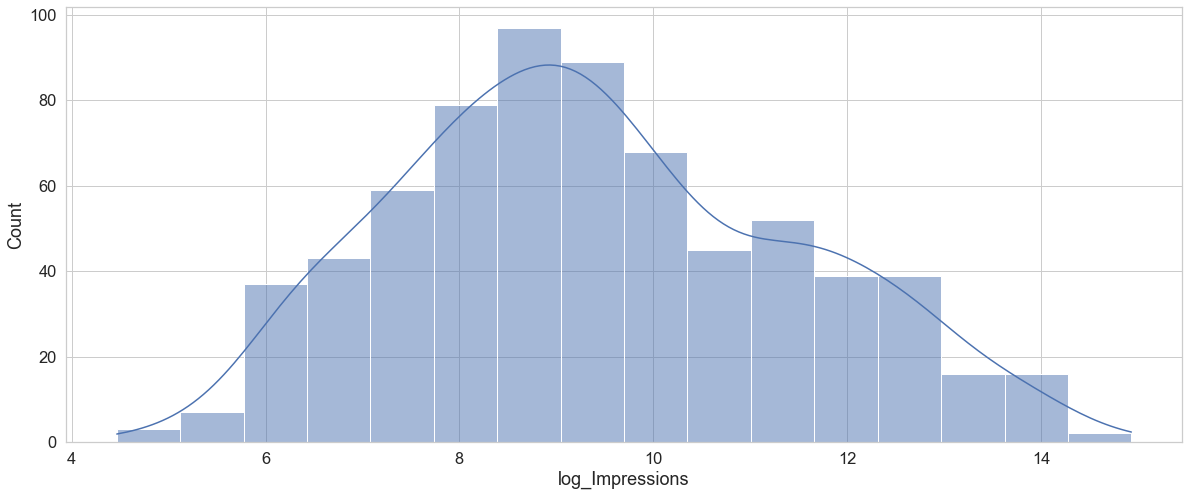

In [10]:
# Визуализируем полученный результат
sns.histplot(fb.log_Impressions, kde=True)

**Выводы:**
- **полученное распределение не является нормальным;**
- **распределение бимодальное.**

<hr>

### 3. Создайте новую колонку c CTR. Посмотрите на описательные статистики и распределение.


Рассчитаем **CTR** *(click-through rate)*, которая показывает кликабельность, т.е. отношение числа кликов к количеству показов. Данная метрика рассчитивается следующим образом: $ CTR= \frac{clicks}{impressions} $

In [11]:
# Рассчитаем CTR и добавим столбец с этой метрикой
df['CTR'] = df.Clicks / df.Impressions
df.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,0.000136
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,0.000112
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0,0.000000
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,0.000235
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,0.000242


In [12]:
# Посмотрим на описательную статистику по CTR
df.CTR.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
CTR,1143.0,0.000164,0.000115,0.0,0.0001,0.00016,0.000234,0.001059


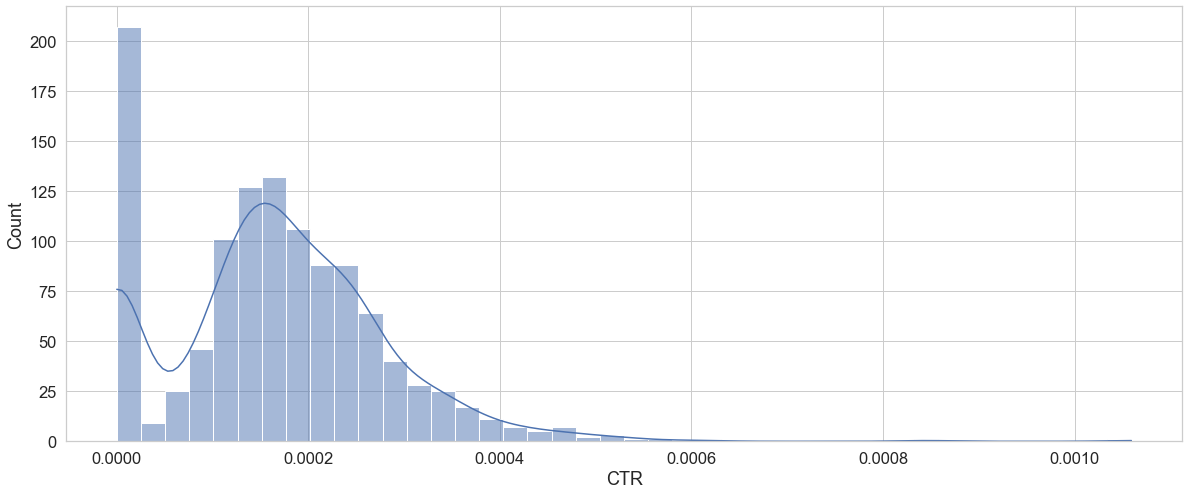

In [13]:
# Визуализируем полученный результат
sns.histplot(df.CTR, kde=True);

**Выводы:**
- **полученное распределение не является нормальным;**
- **распределение имеет положительную ассиметрию;**
- **значительное количество наблюдений имеет значение CTR равное нулю.**

<hr>

### 4. Визуализируйте CTR с разбивкой по номеру рекламной кампании (xyz_campaign_id).

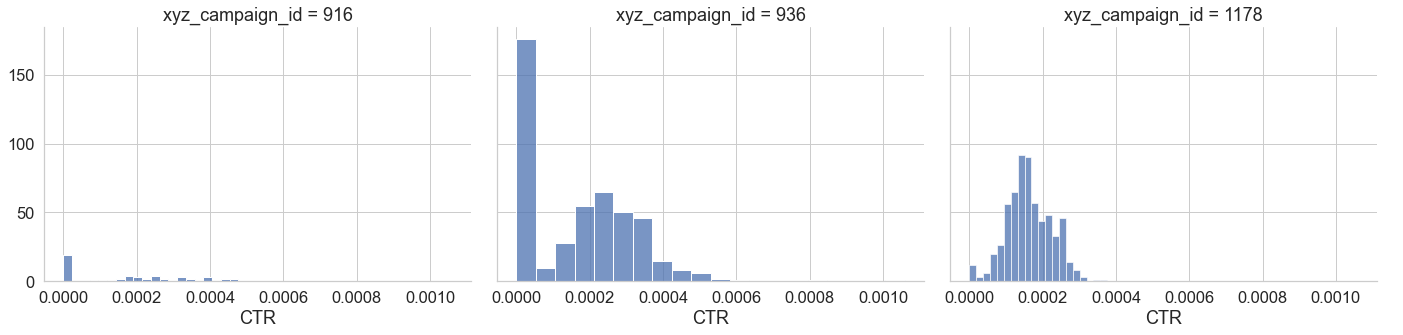

In [14]:
# Построим графики
g = sns.FacetGrid(df, col='xyz_campaign_id', height=5, aspect=1.3)
g.map(sns.histplot, 'CTR', kde=False, bins=20)
g.add_legend();

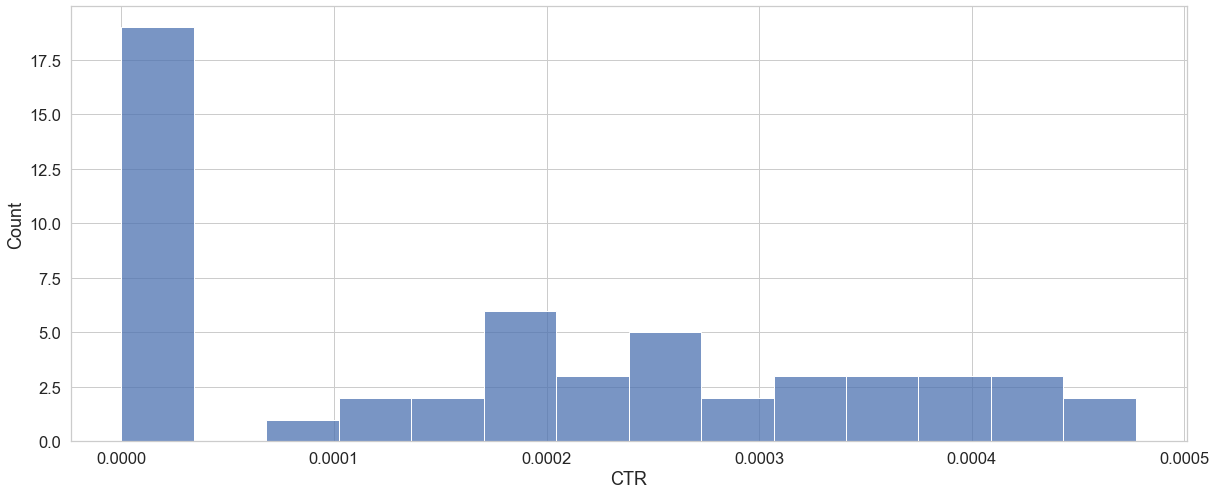

In [15]:
# Посмотрим на распределение CTR кампании 916
id_916 = df.query('xyz_campaign_id == 916')
bins = round(1 + 3.2 * np.log(id_916.shape[0]))
sns.histplot(data=id_916, x='CTR', bins=bins, kde=False);

<hr>

### 5. Посчитайте стоимость за клик пользователя по объявлению. Изучите полученные значения, используя меры центральной тенденции и меры изменчивости. Визуализируйте CPC с разбивкой по полу пользователей, которым были показаны объявления.


Рассчитаем **CPC** *(cost-per-click)* – стоимость за клик пользователя по объявлению, т.е. отношение суммы потраченных денег на общее число кликов. Данная метрика рассчитивается следующим образом: $ CPC = \frac{spent}{clicks} $

In [16]:
# Рассчитаем CTR и добавим столбец с этой метрикой
df['CPC'] = df.Spent / df.Clicks
df.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR,CPC
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,0.000136,1.43
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,0.000112,0.91
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0,0.000000,NaN
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,0.000235,1.25
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,0.000242,1.29


In [17]:
# Посмотрим на описательную статистику по CPC
df.CPC.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
CPC,936.0,1.499347,0.232879,0.18,1.39,1.498273,1.644364,2.212


In [18]:
# Посмотрим на значение межквартильного размаха
stats.iqr(df.CPC, nan_policy='omit').round(4)

0.2544

In [19]:
# Посмотрим на значение коэффициента вариации
stats.variation(df.CPC.dropna()).round(4) * 100

15.52

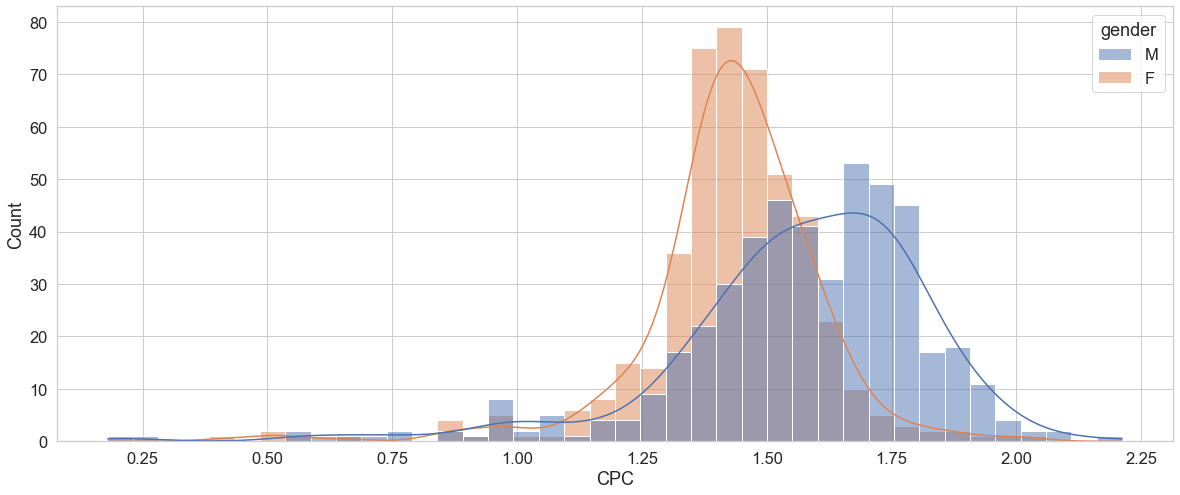

In [20]:
# Визуализируем CPC с разбивкой по полу пользователей
data = df.dropna()
sns.histplot(data=data, x='CPC', hue='gender', kde=True);

<hr>

### 6) Посчитайте конверсию из клика в покупку.

**Конверсия** *(conversion rate)* – отношение числа пользователей, совершивших целевое действие на определенном этапе, к общему числу тех, кто дошел до данного этапа.

In [21]:
df['CR'] = (df.Approved_Conversion / df.Clicks).mul(100)
df.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR,CPC,CR
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,0.000136,1.43,100.0
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,0.000112,0.91,0.0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0,0.000000,NaN,NaN
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,0.000235,1.25,0.0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,0.000242,1.29,100.0
